In [1]:
library(DESeq2)
library(tximport)
library(ggplot2)
library(ggrepel)
library(pheatmap)
library(ggthemes)
library(clusterProfiler)
library(enrichplot)
library("org.Hs.eg.db")
library(variancePartition)

library(tidyverse)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: M

In [2]:
plotPCA_manual = function(object, 
                          intgroup="condition", #essentially ignored if merge_metadata = TRUE
                          ntop=500, 
                          pcs = 2,
                          merge_metadata = FALSE,
                          return_loadings = FALSE,
                          mart_name = "mmusculus",
                          custom_annotation = NULL)
{
#   require(tidyverse)
  
  # calculate the variance for each gene
  rv <- rowVars(assay(object), useNames=TRUE)
  
  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]
  
  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))
  
  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )
  
  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }
  
  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])
  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
  
  # assemble the data for the plot
  d <- data.frame(group=group, intgroup.df, name=colnames(object))
  tmp = pca$x[, 1:pcs]
  colnames(tmp) = paste0("PC", 1:pcs)
  d = cbind(tmp, d)
  attr(d, "percentVar") <- percentVar[1:pcs]
  
  if(merge_metadata == TRUE)
  {
    md = colData(object) %>% 
      as.data.frame() %>% 
      rownames_to_column("sample")
    d = d %>% 
      dplyr::select(-group) %>% 
      dplyr::rename(sample = name) %>% 
      left_join(., md) %>% 
      column_to_rownames("sample")
  }
      
  
  plt = ggplot(data=d, aes_string(x="PC1", y="PC2", color=group)) + geom_point(size=3) + 
    xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
    ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance")) +
    coord_fixed()
  
  #if requested, return loadings in human-readable format
  if(return_loadings == TRUE)
  {
    if(is.null(custom_annotation))
    {
      require(biomaRt)
      mart = useMart("ensembl", paste0(mart_name, "_gene_ensembl"))
      conv = getBM(attributes = c("ensembl_gene_id", "external_gene_name"),
                   mart = mart)
    } else
    {
      conv = custom_annotation
    }
    
    loadings = pca$rotation %>% 
      as.data.frame() %>% 
      rownames_to_column("ensembl_gene_id") %>% 
      left_join(., conv) %>% 
      dplyr::relocate(ensembl_gene_id, external_gene_name) %>% 
      arrange(desc(PC1))
  } else
  {
    loadings = NULL
  }
  
  #output percent variance for each PC as a tidy data frame
  percent_var = data.frame(component = 1:pcs, percent_var = round(percentVar[1:pcs] * 100))
  
  return(list(pca = pca, data = d, plot = plt, loadings = loadings, percent_var = percent_var))
}

In [3]:
fig2.data.dir = "/home/trc891/projects/cyb/2022-CFnose/data/12sala_serial"
fig2.out.dir = "/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/fig3"

In [4]:
data <- read.table(file.path(fig2.data.dir, "htseq.all.counts.txt"), sep='\t', header=TRUE)
data <- dplyr::select(data, -c(Chr, Start, End, Length, Strand))
data <- data / 2 # per Marc, gene counts are doubled
ensemblids <- rownames(data)
#annots <- AnnotationDbi::select(org.Hs.eg.db, keys=as.vector(ensemblids), columns="SYMBOL", keytype="ENSEMBL")

data.noctrl <- dplyr::select(data, -c(uhrna1, uhrna2))

In [5]:
subj.full <- sapply(strsplit(colnames(data.noctrl), split='_'), "[[", 3)
subj <- sapply(strsplit(subj.full, split='\\.'), "[[", 1)

condition <- c('CF', 'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 
               'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 
               'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 
               'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 
               'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 'CF', 
               'HV', 'HV', 'HV', 'HV', 'HV', 'HV', 'HV', 'HV', 'HV', 
               'HV', 'HV'
              )

#v <- c(1, 2, 1, 1, 1, 2, 3, 1, 2, 3, 2, 1, 2, 2, 1, 2, 3, 1, 1, 2, 2,
#       2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, NA, NA, NA, NA, 
#       NA, NA, NA, NA, NA, NA, NA
#      )

# per Marc's documentation, 1A, 9A, and 10A are PwCF and their visits 2/3 are first and second visits
v <- c(1, 2, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, NA, NA, NA, NA, 
       NA, NA, NA, NA, NA, NA, NA
      )

all.coldata <- data.frame(subj=factor(subj), condition=factor(condition), v=factor(v))
rownames(all.coldata) <- colnames(data.noctrl)
all.coldata

,subj,condition,v
,<fct>,<fct>,<fct>
CFNE2_CF10_CF003.1,CF003,CF,1
CFNE2_CF11_CF003.2,CF003,CF,2
CFNE2_CF12_CF004.1,CF004,CF,1
CFNE2_CF13_CF005.1,CF005,CF,1
CFNE2_CF14_CF006.1,CF006,CF,1
CFNE2_CF15_CF006.2,CF006,CF,2
CFNE2_CF16_CF006.3,CF006,CF,3
CFNE2_CF17_CF007.1,CF007,CF,1
CFNE2_CF18_CF007.2,CF007,CF,2


In [6]:
paired.samples <- c("CF002", "CF003", "CF006", "CF007", "CF012", "1A", "10A")
paired.sample.idxs <- c(1, 2)

paired.coldata <- all.coldata[all.coldata$subj %in% paired.samples & all.coldata$v %in% paired.sample.idxs, ]

paired.dds <- DESeqDataSetFromMatrix(countData = data.noctrl[, rownames(paired.coldata)],
                                     colData = paired.coldata,
                                     design = ~ subj + v
                                    )

converting counts to integer mode

factor levels were dropped which had no samples



In [7]:
paired.coldata

,subj,condition,v
,<fct>,<fct>,<fct>
CFNE2_CF10_CF003.1,CF003,CF,1
CFNE2_CF11_CF003.2,CF003,CF,2
CFNE2_CF14_CF006.1,CF006,CF,1
CFNE2_CF15_CF006.2,CF006,CF,2
CFNE2_CF17_CF007.1,CF007,CF,1
CFNE2_CF18_CF007.2,CF007,CF,2
CFNE2_CF1_1A.2,1A,CF,1
CFNE2_CF27_CF012.1,CF012,CF,1
CFNE2_CF28_CF012.2,CF012,CF,2


In [8]:
keep <- rowSums(counts(paired.dds)) >= 10
paired.dds <- paired.dds[keep, ]

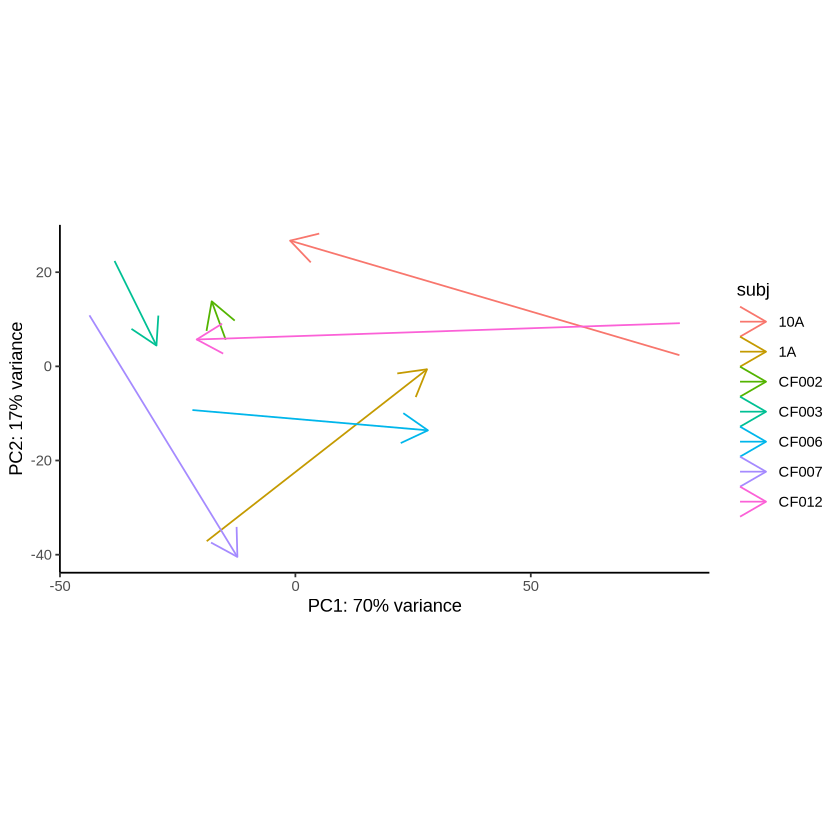

In [9]:
d <- plotPCA(vst(paired.dds), intgroup = c('subj', 'v'), returnData=TRUE)
percentVar <- round(100 * attr(d, "percentVar"))

d.order <- d[order(d$v), ]

ggplot(d, aes(x=PC1, y=PC2, color=subj)) +
    #geom_point(aes(shape=v)) +
    #geom_label_repel(aes(label = cf.dds$subj), show.legend=FALSE) +
    geom_path(arrow=arrow()) +
    xlab(paste0("PC1: ", percentVar[1], "% variance")) +
    ylab(paste0("PC2: ", percentVar[2], "% variance")) +
    coord_fixed() +
    #scale_color_tableau(palette = 'Tableau 10') +
    theme_classic()

ggsave(file.path(fig2.out.dir, "fig3a.png"), height=3, width=3, dpi=300, unit='in')
ggsave(file.path(fig2.out.dir, "fig3a.svg"), height=3, width=3, dpi=300, unit='in')

In [10]:
d.manual <- plotPCA_manual(vst(paired.dds),
                           intgroup=c("subj"),
                           ntop=500,
                           pcs=10,
                          )
percentVar <- round(100 * attr(d.manual$data, "percentVar"))

loadings <- data.frame(d.manual$pca$rotation)
genes <- rownames(loadings)

for (i in 1:10) {
    print(sprintf("PC%d: %d %% variance", i, percentVar[i]))
    l <- loadings[, i]
    ord <- order (abs(l), decreasing=TRUE)
    g <- AnnotationDbi::mapIds(org.Hs.eg.db, as.vector(genes[ord][1:20]), "SYMBOL", "ENSEMBL")
    #g <- genes[ord][1:20]
    vg <- paste(g, " (", round(l[ord][1:20], 4), ")")
    print(paste(vg, collapse=", "))
    print("=========")
}

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


[1] "PC1: 70 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "SRGN  ( 0.0702 ), MME  ( 0.07 ), CXCR2  ( 0.0693 ), FCGR3B  ( 0.0693 ), MNDA  ( 0.0691 ), AQP9  ( 0.0687 ), CXCR1  ( 0.0686 ), BCL2A1  ( 0.0683 ), FPR1  ( 0.0683 ), PROK2  ( 0.0676 ), SLC2A3  ( 0.0676 ), CSF3R  ( 0.0673 ), RGS2  ( 0.0673 ), CXCL8  ( 0.067 ), FPR2  ( 0.067 ), G0S2  ( 0.0659 ), TNFRSF10C  ( 0.0657 ), SELL  ( 0.0657 ), C5AR1  ( 0.0649 ), IL1B  ( 0.0646 )"
[1] "========="
[1] "PC2: 17 % variance"


'select()' returned 1:many mapping between keys and columns



[1] "FAM216B  ( 0.0969 ), CCDC170  ( 0.0928 ), TPPP3  ( 0.0926 ), FOXJ1  ( 0.0912 ), SPAG6  ( 0.0902 ), C20orf85  ( 0.09 ), DNAH9  ( 0.0888 ), VWA3B  ( 0.0877 ), CCDC17  ( 0.0876 ), CDHR3  ( 0.0873 ), PIFO  ( 0.0872 ), RSPH4A  ( 0.0863 ), ROPN1L  ( 0.0863 ), CFAP45  ( 0.0858 ), DRC1  ( 0.0855 ), OMG  ( 0.0849 ), C9orf24  ( 0.0848 ), DNALI1  ( 0.0834 ), RSPH1  ( 0.0833 ), WDR38  ( 0.0833 )"
[1] "========="
[1] "PC3: 6 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "PSORS1C1  ( 0.1496 ), CDSN  ( 0.1486 ), LCE3D  ( 0.1354 ), SPRR2G  ( 0.1285 ), CNFN  ( 0.1245 ), LORICRIN  ( 0.1242 ), CRCT1  ( 0.1241 ), ASPRV1  ( 0.1219 ), SBSN  ( 0.1211 ), NDRG4  ( 0.1201 ), KRT24  ( -0.119 ), CLDN17  ( 0.1159 ), KRT1  ( 0.1147 ), KPRP  ( 0.1125 ), SPINK7  ( 0.1123 ), SPRR2B  ( 0.1083 ), TRPV3  ( 0.1076 ), SPRR2E  ( 0.1069 ), RNASE7  ( 0.1065 ), EREG  ( 0.1061 )"
[1] "========="
[1] "PC4: 2 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "COL17A1  ( -0.2596 ), KRT14  ( -0.2414 ), XIST  ( -0.2405 ), TSIX  ( -0.2314 ), DDX3Y  ( 0.2305 ), FN1  ( -0.2279 ), COL1A2  ( -0.2119 ), S100A2  ( -0.1896 ), COL3A1  ( -0.1661 ), MUC5AC  ( 0.138 ), NA  ( -0.1333 ), KRT24  ( -0.1166 ), SLC12A5-AS1  ( -0.1158 ), FCGBP  ( 0.1156 ), TRPV3  ( 0.1063 ), NAMPTP1  ( 0.1053 ), KRT17  ( -0.1048 ), MMP9  ( -0.1036 ), GBP5  ( 0.103 ), SPRR2B  ( 0.1023 )"
[1] "========="
[1] "PC5: 1 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "HBB  ( 0.3031 ), MUC5AC  ( -0.1518 ), SLC26A4  ( -0.1433 ), NA  ( 0.1378 ), SPINK6  ( 0.1367 ), FLG  ( -0.1343 ), SCGB3A1  ( -0.1311 ), KRT14  ( 0.1226 ), DDX3Y  ( 0.1221 ), CRNN  ( -0.1215 ), GBP5  ( 0.1214 ), CXCL10  ( 0.1211 ), S100A2  ( 0.1207 ), COL1A2  ( -0.1172 ), KRT6B  ( 0.1172 ), CXCL9  ( 0.1147 ), IVL  ( 0.1081 ), SBSN  ( 0.1065 ), SERPINB9  ( 0.1038 ), HCAR2  ( 0.0996 )"
[1] "========="
[1] "PC6: 1 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "BPIFA1  ( -0.2984 ), SCGB3A1  ( -0.2218 ), NA  ( -0.1867 ), CXCL10  ( 0.1761 ), SPRR2G  ( -0.1719 ), KRT24  ( 0.168 ), KRT1  ( -0.1564 ), CRNN  ( 0.1306 ), BPIFB1  ( -0.1303 ), MAL  ( 0.1287 ), CXCL9  ( 0.1281 ), TMPRSS11B  ( 0.126 ), LCE3D  ( -0.1138 ), FCGBP  ( -0.1138 ), CXCL5  ( -0.1113 ), SPINK7  ( 0.1111 ), FN1  ( -0.1082 ), LCE3E  ( -0.1056 ), VSIG10L  ( 0.0992 ), ECM1  ( 0.0983 )"
[1] "========="
[1] "PC7: 1 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "COL3A1  ( -0.2166 ), KRT1  ( 0.1739 ), MMP9  ( -0.1556 ), SLC26A4  ( -0.1552 ), GABRQ  ( -0.154 ), MUC5AC  ( 0.1435 ), CXCL10  ( -0.1405 ), HBB  ( -0.14 ), SLC12A5-AS1  ( -0.119 ), NA  ( 0.1171 ), MAL  ( 0.1089 ), FLG  ( 0.1075 ), CXCL5  ( -0.1071 ), TRPV3  ( -0.1065 ), DUSP1  ( 0.105 ), NA  ( 0.1045 ), SPRR2G  ( 0.1035 ), TMPRSS11B  ( 0.1011 ), CRNN  ( 0.0997 ), XIST  ( -0.0994 )"
[1] "========="
[1] "PC8: 1 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "HBB  ( 0.2417 ), FN1  ( -0.1861 ), GBP5  ( -0.1606 ), XIST  ( -0.1593 ), CXCL9  ( -0.1552 ), DDX3Y  ( 0.1529 ), PIK3CG  ( -0.1525 ), CXCL10  ( -0.143 ), KRT1  ( -0.1385 ), MUC2  ( 0.1306 ), TSIX  ( -0.1262 ), OSM  ( 0.1251 ), KRT24  ( 0.1233 ), CXCL5  ( -0.106 ), FOS  ( 0.1059 ), BPIFA1  ( 0.1043 ), MMP9  ( -0.1015 ), SPRR2G  ( -0.1013 ), ITGAL  ( -0.0988 ), RGS2  ( 0.0986 )"
[1] "========="
[1] "PC9: 0 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "NA  ( 0.2532 ), COL3A1  ( 0.2087 ), DDX3Y  ( 0.1963 ), XIST  ( -0.1882 ), FN1  ( 0.1865 ), TSIX  ( -0.1751 ), NA  ( -0.1743 ), NA  ( 0.1726 ), COL1A2  ( 0.1686 ), SLC26A4  ( -0.1542 ), FCGBP  ( -0.1527 ), FLG  ( 0.1304 ), MMP9  ( 0.1251 ), SPRR2F  ( -0.1238 ), CXCL10  ( 0.1209 ), CXCL9  ( 0.119 ), SLC12A5-AS1  ( 0.1119 ), PLPPR3  ( 0.1107 ), RFLNB  ( 0.1039 ), LORICRIN  ( 0.1032 )"
[1] "========="
[1] "PC10: 0 % variance"


'select()' returned 1:1 mapping between keys and columns



[1] "NA  ( -0.2136 ), BPIFB1  ( 0.1969 ), KRT14  ( 0.1737 ), NFE4  ( 0.1726 ), NAMPTP1  ( 0.1653 ), MUC5AC  ( 0.1562 ), CFD  ( 0.1525 ), FCGBP  ( 0.1464 ), MMP9  ( 0.1454 ), FN1  ( 0.1412 ), PSORS1C1  ( -0.1273 ), KRT6A  ( 0.1269 ), NA  ( -0.1229 ), KRT24  ( 0.1172 ), CDSN  ( -0.1149 ), COL3A1  ( 0.1138 ), S100A2  ( 0.1136 ), HEPHL1  ( 0.111 ), SLC12A5-AS1  ( 0.1026 ), HSD17B13  ( -0.1021 )"
[1] "========="


In [11]:
paired.dds <- DESeq(paired.dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [12]:
v2.vs.v1 <- as.data.frame(results(paired.dds, contrast=c('v', '2', '1')))
v2.vs.v1 <- v2.vs.v1[!is.na(v2.vs.v1$padj), ]
v2.vs.v1$sign <- ""
v2.vs.v1$sign[(v2.vs.v1$log2FoldChange < 0) & (v2.vs.v1$padj < 0.05)] <- "Down"
v2.vs.v1$sign[(v2.vs.v1$log2FoldChange > 0) & (v2.vs.v1$padj < 0.05)] <- "Up"
v2.vs.v1 <- v2.vs.v1[order(v2.vs.v1$sign), ]

v2.vs.v1.genenames <- AnnotationDbi::mapIds(org.Hs.eg.db, as.vector(rownames(v2.vs.v1)), "SYMBOL", "ENSEMBL")
v2.vs.v1$genenames <- v2.vs.v1.genenames

'select()' returned 1:many mapping between keys and columns



In [13]:
v2.vs.v1[v2.vs.v1$padj < 0.05, ]

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sign,genenames
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>


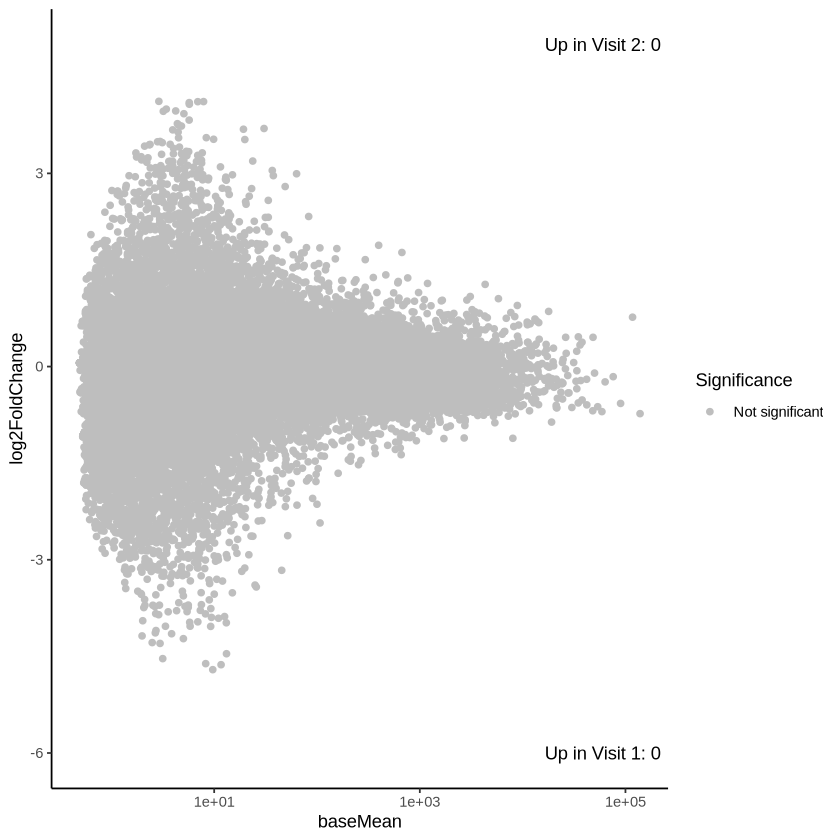

In [14]:
ggplot(v2.vs.v1, aes(x=baseMean, y=log2FoldChange)) +
    geom_point(aes(fill=sign, color=sign), stroke=0.5) +
    # ylim(-10, 10)
    #geom_label_repel(
    #    aes(label = GENENAME, fontface = "italic"), 
    #    data = v2.vs.v1[v2.vs.v1$padj < 0.05, ],
    #    box.padding = 0.5,
    #    seed = 5000,
    #) +
    scale_x_log10() +
    scale_color_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) +
    scale_fill_manual(values = c("gray", "darkred", "blue"), name = "Significance", labels = c("Not significant", "Downregulated", "Upregulated")) + 
    annotate("text", x = 6e+04, y = 5, label = sprintf("Up in Visit 2: %d", sum(v2.vs.v1$sign == "Up"))) +
    annotate("text", x = 6e+04, y = -6, label = sprintf("Up in Visit 1: %d", sum(v2.vs.v1$sign == "Down"))) +
    theme_classic()

ggsave(file.path(fig2.out.dir, "fig3b.png"), height=4, width=8, dpi=300, unit='in')
ggsave(file.path(fig2.out.dir, "fig3b.svg"), height=4, width=8, dpi=300, unit='in')

## Correlation

In [15]:
paired.cor.mtx <- cor(counts(paired.dds, normalized=TRUE), method = 'spearman')

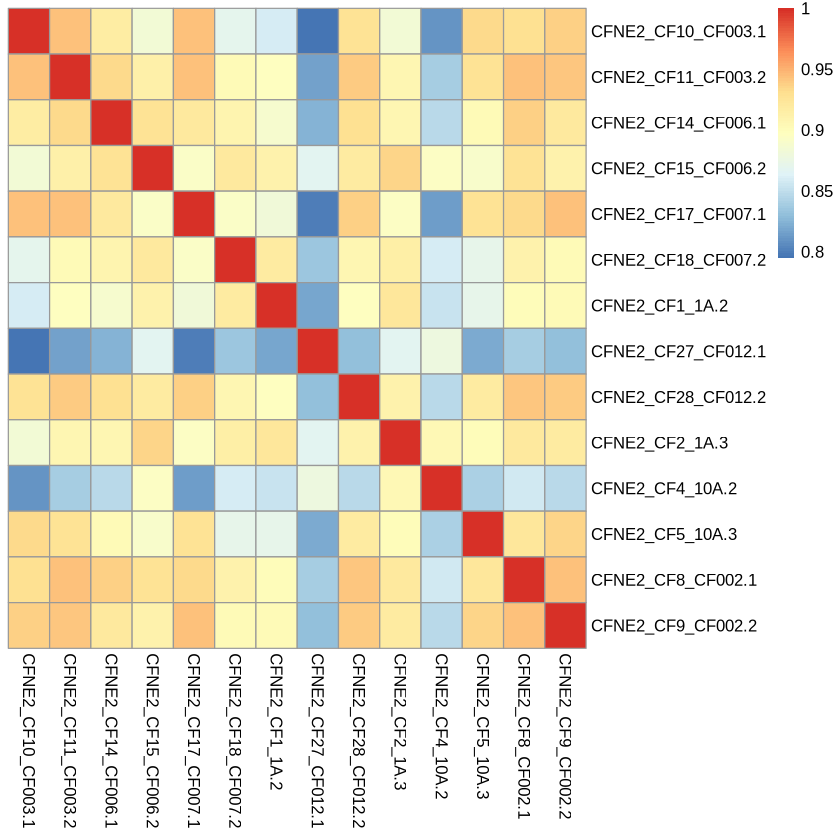

In [16]:
p <- pheatmap(paired.cor.mtx, cluster_rows=FALSE, cluster_cols=FALSE)

#ggsave(file.path(fig2.out.dir, "fig2c.png"), plot=p, height=3, width=4.5, dpi=300, unit='in')

In [17]:
file.path(fig2.out.dir, "fig2c.png")

[1] "/home/trc891/projects/cyb/2022-CFnose/data/10paper_figures/fig3/fig2c.png"

In [18]:
paired.cor.tri <- paired.cor.mtx
paired.cor.tri[lower.tri(paired.cor.mtx, diag=TRUE)] <- NA
paired.cor.tri

,CFNE2_CF10_CF003.1,CFNE2_CF11_CF003.2,CFNE2_CF14_CF006.1,CFNE2_CF15_CF006.2,CFNE2_CF17_CF007.1,CFNE2_CF18_CF007.2,CFNE2_CF1_1A.2,CFNE2_CF27_CF012.1,CFNE2_CF28_CF012.2,CFNE2_CF2_1A.3,CFNE2_CF4_10A.2,CFNE2_CF5_10A.3,CFNE2_CF8_CF002.1,CFNE2_CF9_CF002.2
CFNE2_CF10_CF003.1,NA,0.9427948,0.9178106,0.8831183,0.9429931,0.8690934,0.8603731,0.7946924,0.9278809,0.8830638,0.8097460,0.9337602,0.9299031,0.9372838
CFNE2_CF11_CF003.2,NA,NA,0.9332810,0.9134617,0.9433930,0.9027981,0.8965767,0.8158411,0.9401615,0.9070931,0.8391328,0.9273399,0.9432357,0.9406628
CFNE2_CF14_CF006.1,NA,NA,NA,0.9268402,0.9210217,0.9080098,0.8883789,0.8234439,0.9298803,0.9060712,0.8473541,0.9017841,0.9372145,0.9207643
CFNE2_CF15_CF006.2,NA,NA,NA,NA,0.8914164,0.9210571,0.9096699,0.8684763,0.9187127,0.9346501,0.8950896,0.8906097,0.9266930,0.9113825
CFNE2_CF17_CF007.1,NA,NA,NA,NA,NA,0.8927951,0.8826789,0.7991621,0.9383445,0.8932908,0.8142130,0.9280194,0.9342419,0.9445037
CFNE2_CF18_CF007.2,NA,NA,NA,NA,NA,NA,0.9180072,0.8353657,0.9074999,0.9148305,0.8601174,0.8710084,0.9108052,0.9025293
CFNE2_CF1_1A.2,NA,NA,NA,NA,NA,NA,NA,0.8180709,0.8967208,0.9238074,0.8530579,0.8721842,0.8997773,0.9022062
CFNE2_CF27_CF012.1,NA,NA,NA,NA,NA,NA,NA,NA,0.8302100,0.8679915,0.8773315,0.8196830,0.8388099,0.8298597
CFNE2_CF28_CF012.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.9112771,0.8465022,0.9191548,0.9415187,0.9402953
CFNE2_CF2_1A.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.9043840,0.8999120,0.9201750,0.9182993


In [19]:
mean(diag(paired.cor.tri[rownames(paired.coldata[paired.coldata$v == 1, ]),
                         rownames(paired.coldata[paired.coldata$v == 2, ])]))

[1] 0.9017377

In [20]:
mean(paired.cor.tri, na.rm=TRUE)

[1] 0.8949316

In [21]:
t.test(diag(paired.cor.tri[rownames(paired.coldata[paired.coldata$v == 1, ]),
                         rownames(paired.coldata[paired.coldata$v == 2, ])]),
       na.omit(as.vector(paired.cor.tri))
      )


	Welch Two Sample t-test

data:  diag(paired.cor.tri[rownames(paired.coldata[paired.coldata$v == 1, ]), rownames(paired.coldata[paired.coldata$v == 2, ])]) and na.omit(as.vector(paired.cor.tri))
t = 0.44797, df = 7.0481, p-value = 0.6676
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02907107  0.04268337
sample estimates:
mean of x mean of y 
0.9017377 0.8949316 
